# Advisory mission for the Boston municipal authorities


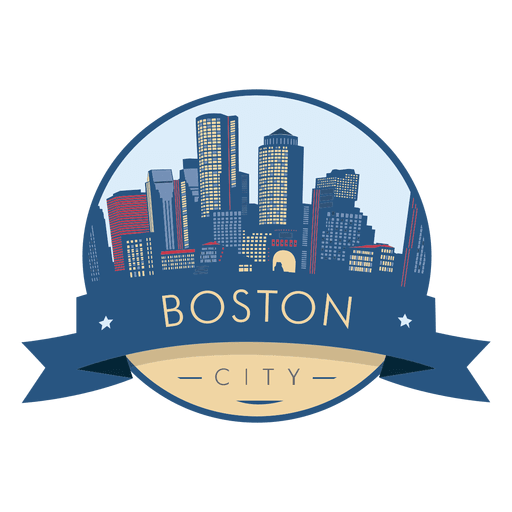


This project is based on the dataset available on this website : https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system
We will extract information from this dataset and use decision science to help the city of boston take action on crime


## Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.formula.api as smf


## Extraction



We want to look at how the socioeconomic makeup of the various neighborhoods in Boston affects the volume of reported and actual crimes. In order to achieve this, we must extract the pertinent dataset. Each row should correspond to one of Boston's 12 police districts, which are specified in the database's "districts" table.


In [2]:
query = """SELECT 
districts.CODE,
districts.NAME,
COUNT(incident_reports.INCIDENT_NUMBER ) AS NB_INCIDENTS,
indicators.MEDIAN_AGE,
indicators.TOTAL_POP,
indicators.PERC_OF_30_34,
indicators.PERC_MARRIED_COUPLE_FAMILY,
indicators.PER_CAPITA_INCOME,
indicators.PERC_OTHER_STATE_OR_ABROAD,
indicators.PERC_LESS_THAN_HIGH_SCHOOL,
indicators.PERC_COLLEGE_GRADUATES 
FROM incident_reports 
JOIN districts ON incident_reports.DISTRICT  = districts.CODE
JOIN indicators ON districts.CODE  = indicators.CODE 
GROUP BY  districts.CODE
ORDER BY districts.CODE ASC
"""


In [3]:
conn = sqlite3.connect("db/boston_crimes.sqlite")
crimes_df = pd.read_sql(query, conn)
crimes_df



CODE           NAME  NB_INCIDENTS  MEDIAN_AGE  TOTAL_POP  PERC_OF_30_34  \
0    A1       Downtown         26260        33.5      18306           32.5   
1   A15    Charlestown          4765        35.7      19890           28.2   
2    A7    East Boston          9691        30.6      47263           31.1   
3    B2        Roxbury         38877        32.5      54161           27.8   
4    B3       Mattapan         28331        36.7      26659           20.9   
5   C11     Dorchester         32875        33.4     126909           28.2   
6    C6   South Boston         16617        31.9      36772           46.1   
7   D14       Brighton         13788        30.8      55297           52.8   
8    D4      South End         31258        37.1      32571           33.9   
9   E13  Jamaica Plain         12802        34.8      40867           32.5   
10  E18      Hyde Park         12551        39.4      38924           21.1   
11   E5   West Roxbury          9406        42.8      33526           18.1   

    PERC_MARRIED_COUPLE_FAMILY  PER_CAPITA_INCOME  PERC_OTHER_STATE_OR_ABROAD  \
0                         35.8              80057                        14.8   
1                         36.4              75339                         3.4   
2                         30.4              31473                         3.5   
3                         17.8              20978                         2.9   
4                         29.8              28356                         2.3   
5                         26.6              29767                         2.4   
6                         24.7              64745                         2.4   
7                         26.4              41261                         8.6   
8                         28.3              83609                         6.2   
9                         33.7              51655                         5.5   
10                        38.4              32744                         1.9   
11                        46.2              47836                         1.9   

    PERC_LESS_THAN_HIGH_SCHOOL  PERC_COLLEGE_GRADUATES  
0                         15.4                     6.9  
1                          7.9                     8.2  
2                         27.2                    11.5  
3                         23.0                    18.9  
4                         14.5                    22.9  
5                         18.0                    17.1  
6                          7.9                     8.4  
7                          6.7                    10.5  
8                         11.8                     8.5  
9                          8.0                    12.1  
10                        13.8                    21.3  
11                         6.5                    13.2

In [4]:
crimes_df.shape


(12, 11)

In [5]:
crimes_df.head(5)


CODE         NAME  NB_INCIDENTS  MEDIAN_AGE  TOTAL_POP  PERC_OF_30_34  \
0   A1     Downtown         26260        33.5      18306           32.5   
1  A15  Charlestown          4765        35.7      19890           28.2   
2   A7  East Boston          9691        30.6      47263           31.1   
3   B2      Roxbury         38877        32.5      54161           27.8   
4   B3     Mattapan         28331        36.7      26659           20.9   

   PERC_MARRIED_COUPLE_FAMILY  PER_CAPITA_INCOME  PERC_OTHER_STATE_OR_ABROAD  \
0                        35.8              80057                        14.8   
1                        36.4              75339                         3.4   
2                        30.4              31473                         3.5   
3                        17.8              20978                         2.9   
4                        29.8              28356                         2.3   

   PERC_LESS_THAN_HIGH_SCHOOL  PERC_COLLEGE_GRADUATES  
0                        15.4                     6.9  
1                         7.9                     8.2  
2                        27.2                    11.5  
3                        23.0                    18.9  
4                        14.5                    22.9

# Linear regression


Our target is the number of incidents


We will focus on the following regressors: 

- the **median age** in the district, whose effect is difficult to anticipate on the number of crimes;
 
 
- the **percentage of 30-34 years old** in the district, whose effect is also unclear a priori;
 
 
- the **share of families with a married couple** among all households, which could be anticipated to have a negative effect on criminality (more attention to safety among residents...);
 
 
- the **percentage of residents having moved from abroad or from another US state over the last year**, mobility being often associated with social marginalisation and possibly with a higher risk of resorting to illegal activities;
 
 
- the **percentage of residents having stopped their studies before getting a high school degree**. Economic models would suggest that due to the more narrow job opportunities to which this group has access, the incentive is stronger to resort to illicit activities;
 
 
- the **percentage of college graduates** in the district, which we would expect to have an opposite effect.


In [6]:
import statsmodels.api as sm
X = crimes_df[['MEDIAN_AGE',
          'PERC_OF_30_34',
          'PERC_MARRIED_COUPLE_FAMILY',
          'PERC_OTHER_STATE_OR_ABROAD',
          'PERC_LESS_THAN_HIGH_SCHOOL',
          'PERC_COLLEGE_GRADUATES']]

Y = crimes_df['NB_INCIDENTS']


In [7]:
X.shape,Y.shape



((12, 6), (12,))

In [8]:
model = sm.OLS(Y, X).fit()
model.predict(X)


0     24226.739206
1      8460.587128
2     11347.773857
3     42355.347903
4     28032.581183
5     23961.272985
6     13911.404744
7     15603.501331
8     32279.496506
9     13945.617820
10    15710.900264
11     7286.939227
dtype: float64

In [9]:
model.params


MEDIAN_AGE                    2495.809092
PERC_OF_30_34                 -437.546390
PERC_MARRIED_COUPLE_FAMILY   -2098.037153
PERC_OTHER_STATE_OR_ABROAD    1788.825664
PERC_LESS_THAN_HIGH_SCHOOL     205.854613
PERC_COLLEGE_GRADUATES          43.817611
dtype: float64

**We can say that the median age is associated with a positive effect on the number of crime incidents**


In [10]:
model.summary()



/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           NB_INCIDENTS   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              42.36
Date:                Fri, 10 Feb 2023   Prob (F-statistic):                    0.000118
Time:                        18:25:59   Log-Likelihood:                         -114.64
No. Observations:                  12   AIC:                                      241.3
Df Residuals:                       6   BIC:                                      244.2
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
MEDIAN_AGE                  2495.8091    513.971      4.856      0.003    1238.167    3753.451
PERC_OF_30_34               -437.5464    164.517     -2.660      0.038    -840.105     -34.987
PERC_MARRIED_COUPLE_FAMILY -2098.0372    367.703     -5.706      0.001   -2997.773   -1198.301
PERC_OTHER_STATE_OR_ABROAD  1788.8257    488.372      3.663      0.011     593.823    2983.829
PERC_LESS_THAN_HIGH_SCHOOL   205.8546    234.482      0.878      0.414    -367.902     779.611
PERC_COLLEGE_GRADUATES        43.8176    408.436      0.107      0.918    -955.589    1043.224
==============================================================================
Omnibus:                        8.198   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                3.962
Skew:                           1.271   Prob(JB):                        0.138
Kurtosis:                       4.209   Cond. No.                         29.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The p value for median_age is equal to 0.003.**


We can say that the median_age feature is statistically significant at 95% confidence level or 90% confidence level because the pvalue is under 0.05.



In [11]:
model.params['PERC_MARRIED_COUPLE_FAMILY']


-2098.0371531809983

If we hold all other regressors constant,
the total of the number of incidents in the district decrease by 2098.037
when the percentage of families with a married couple increase by 1.


### Main limitations


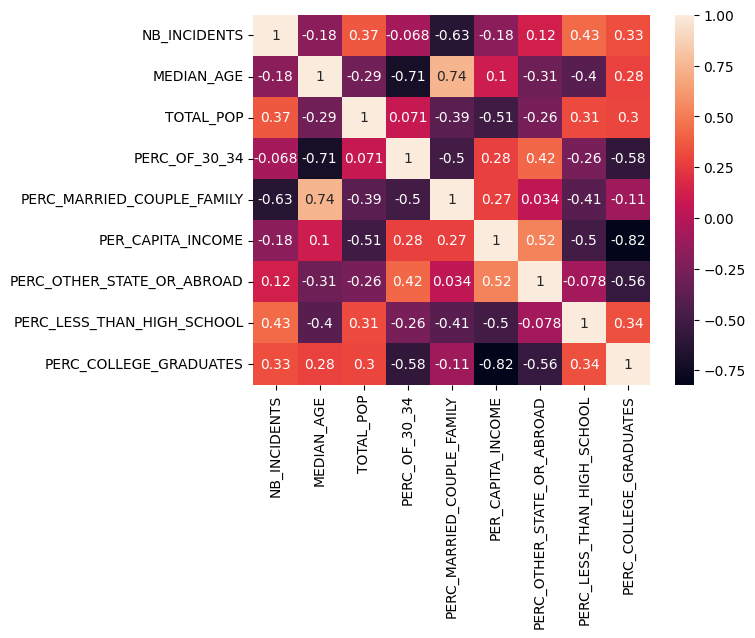

In [12]:
import seaborn as sns
sns.heatmap(data=crimes_df.corr(),annot=True);


The main limitations of this regression are multicolinearity between features, overfitting and 
the presumption that the relationship between the dependent and independent variables is linear.



# Analysis


In [13]:
data_1 = pd.read_csv("data/incident_reports.csv")
data_2 = pd.read_csv("data/districts.csv")
data_1.shape,data_2.shape




((237221, 7), (12, 4))

In [14]:
data_1= data_1.merge(
        data_2[['CODE', 'NAME', 'LAT_POLICE_STATION', 'LONG_POLICE_STATION']],
        how='inner',
        left_on='DISTRICT', right_on='CODE'
    )

data_1.drop(columns=['DISTRICT', 'CODE'], inplace=True)

data_1.head()


INCIDENT_NUMBER       OFFENSE_CODE_GROUP  SHOOTING     OCCURRED_ON_DATE  \
0      I192068249                    Other         0  2015-08-28 10:20:00   
1      I182074094  Violence and harassment         0  2015-09-14 09:31:00   
2      I182054888  Violence and harassment         0  2015-07-12 15:37:00   
3      I182054888                    Other         0  2015-07-12 15:37:00   
4      I182054888                    Other         0  2015-07-12 15:37:00   

         LAT       LONG     NAME  LAT_POLICE_STATION  LONG_POLICE_STATION  
0  42.330119 -71.084251  Roxbury           42.328894           -71.085359  
1  42.315142 -71.067047  Roxbury           42.328894           -71.085359  
2  42.312243 -71.075499  Roxbury           42.328894           -71.085359  
3  42.312243 -71.075499  Roxbury           42.328894           -71.085359  
4  42.312243 -71.075499  Roxbury           42.328894           -71.085359

In [15]:
data_full = data_1.copy()


In [16]:
data_full[['LAT','LONG']] = data_full[['LAT','LONG']].astype('float64')

print("Shape of the DataFrame:", data_full.shape)

data_full.head()

Shape of the DataFrame: (237221, 9)


INCIDENT_NUMBER       OFFENSE_CODE_GROUP  SHOOTING     OCCURRED_ON_DATE  \
0      I192068249                    Other         0  2015-08-28 10:20:00   
1      I182074094  Violence and harassment         0  2015-09-14 09:31:00   
2      I182054888  Violence and harassment         0  2015-07-12 15:37:00   
3      I182054888                    Other         0  2015-07-12 15:37:00   
4      I182054888                    Other         0  2015-07-12 15:37:00   

         LAT       LONG     NAME  LAT_POLICE_STATION  LONG_POLICE_STATION  
0  42.330119 -71.084251  Roxbury           42.328894           -71.085359  
1  42.315142 -71.067047  Roxbury           42.328894           -71.085359  
2  42.312243 -71.075499  Roxbury           42.328894           -71.085359  
3  42.312243 -71.075499  Roxbury           42.328894           -71.085359  
4  42.312243 -71.075499  Roxbury           42.328894           -71.085359

### Most represented type of incident per district


In [17]:
df_most_represented = data_full.groupby("NAME").agg({"OFFENSE_CODE_GROUP": lambda x: x.value_counts().index[0]})
df_most_represented


OFFENSE_CODE_GROUP
NAME                                         
Brighton                Larceny and vandalism
Charlestown             Larceny and vandalism
Dorchester              Larceny and vandalism
Downtown                Larceny and vandalism
East Boston             Larceny and vandalism
Hyde Park               Larceny and vandalism
Jamaica Plain           Larceny and vandalism
Mattapan       Police investigation procedure
Roxbury                 Larceny and vandalism
South Boston            Larceny and vandalism
South End               Larceny and vandalism
West Roxbury            Larceny and vandalism

In [18]:
df_second_represented = data_full.groupby("NAME").agg({"OFFENSE_CODE_GROUP": lambda x: x.value_counts().index[1]})

df_second_represented


OFFENSE_CODE_GROUP
NAME                                         
Brighton       Police investigation procedure
Charlestown    Police investigation procedure
Dorchester     Police investigation procedure
Downtown       Police investigation procedure
East Boston    Police investigation procedure
Hyde Park      Police investigation procedure
Jamaica Plain  Police investigation procedure
Mattapan                Larceny and vandalism
Roxbury        Police investigation procedure
South Boston   Police investigation procedure
South End      Police investigation procedure
West Roxbury   Police investigation procedure

In [19]:
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance (km) between two pairs of (lat, lng) coordinates
    """
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    
    return 2 * 6371 * asin(sqrt(a))


In [20]:
data_full["Distance"] = data_full.apply(lambda x: haversine_distance(x["LONG"], x["LAT"], x["LONG_POLICE_STATION"], x["LAT_POLICE_STATION"]), axis=1)
distance_avg = data_full.groupby("NAME").agg({"Distance": "mean"})
distance_avg.rename(columns={"Distance": "Average Distance"}, inplace=True)
distance_avg = distance_avg.sort_values(by="Average Distance")

distance_avg


Average Distance
NAME                           
South End              1.862039
Mattapan               1.908636
Hyde Park              2.397613
Jamaica Plain          2.585737
Roxbury                2.989029
Dorchester             3.174444
Brighton               3.770867
East Boston            5.568626
Downtown               6.336657
West Roxbury          18.370045
South Boston          31.454220
Charlestown           58.758394

# Presentation for the Boston council


In [21]:
data_slides = data_full.copy()
data_slides


INCIDENT_NUMBER              OFFENSE_CODE_GROUP  SHOOTING  \
0           I192068249                           Other         0   
1           I182074094         Violence and harassment         0   
2           I182054888         Violence and harassment         0   
3           I182054888                           Other         0   
4           I182054888                           Other         0   
...                ...                             ...       ...   
237216      I172049757  Police investigation procedure         0   
237217      I172049757    Drugs and disorderly conduct         0   
237218      I172027369                           Other         0   
237219      I172027369  Police investigation procedure         0   
237220      I172027369         Violence and harassment         0   

           OCCURRED_ON_DATE        LAT       LONG         NAME  \
0       2015-08-28 10:20:00  42.330119 -71.084251      Roxbury   
1       2015-09-14 09:31:00  42.315142 -71.067047      Roxbury   
2       2015-07-12 15:37:00  42.312243 -71.075499      Roxbury   
3       2015-07-12 15:37:00  42.312243 -71.075499      Roxbury   
4       2015-07-12 15:37:00  42.312243 -71.075499      Roxbury   
...                     ...        ...        ...          ...   
237216  2018-08-09 18:00:00  42.355216 -71.060129  Charlestown   
237217  2018-08-09 18:00:00  42.355216 -71.060129  Charlestown   
237218  2018-12-12 05:00:00  42.376852 -71.068873  Charlestown   
237219  2018-12-12 05:00:00  42.376852 -71.068873  Charlestown   
237220  2018-12-12 05:00:00  42.376852 -71.068873  Charlestown   

        LAT_POLICE_STATION  LONG_POLICE_STATION  Distance  
0                42.328894           -71.085359  0.163832  
1                42.328894           -71.085359  2.145919  
2                42.328894           -71.085359  2.021175  
3                42.328894           -71.085359  2.021175  
4                42.328894           -71.085359  2.021175  
...                    ...                  ...       ...  
237216           42.361800           -71.060300  0.732215  
237217           42.361800           -71.060300  0.732215  
237218           42.361800           -71.060300  1.815839  
237219           42.361800           -71.060300  1.815839  
237220           42.361800           -71.060300  1.815839  

[237221 rows x 10 columns]

## Use of datetime


In [22]:
data_slides["OCCURRED_ON_DATE"] = pd.to_datetime(data_slides["OCCURRED_ON_DATE"])
data_slides.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 237221 entries, 0 to 237220
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   INCIDENT_NUMBER      237221 non-null  object        
 1   OFFENSE_CODE_GROUP   237221 non-null  object        
 2   SHOOTING             237221 non-null  int64         
 3   OCCURRED_ON_DATE     237221 non-null  datetime64[ns]
 4   LAT                  237221 non-null  float64       
 5   LONG                 237221 non-null  float64       
 6   NAME                 237221 non-null  object        
 7   LAT_POLICE_STATION   237221 non-null  float64       
 8   LONG_POLICE_STATION  237221 non-null  float64       
 9   Distance             237221 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 19.9+ MB


In [23]:
data_slides["Year"]=data_slides["OCCURRED_ON_DATE"].dt.year
data_slides["Month"] = data_slides["OCCURRED_ON_DATE"].dt.month
data_slides["Day"] = data_slides["OCCURRED_ON_DATE"].dt.day
data_slides["Day_of_week"] = data_slides["OCCURRED_ON_DATE"].dt.day_of_week
data_slides["Hour"]=data_slides["OCCURRED_ON_DATE"].dt.hour


In [24]:
data_slides = data_slides.sort_values(by="OCCURRED_ON_DATE")
data_slides


INCIDENT_NUMBER              OFFENSE_CODE_GROUP  SHOOTING  \
43282       I152059178                           Other         0   
145652      I152054279        Fraud and law violations         0   
74932       I152067251        Fraud and law violations         0   
185670      I152051083  Police investigation procedure         0   
38887       I172040657         Violence and harassment         0   
...                ...                             ...       ...   
180232      I182105271         Violence and harassment         0   
214825      I192000001  Police investigation procedure         0   
200583      I192000256           Larceny and vandalism         0   
133540      I192000002  Police investigation procedure         0   
28440       I192000425           Larceny and vandalism         0   

          OCCURRED_ON_DATE        LAT       LONG          NAME  \
43282  2015-06-15 00:00:00  42.293606 -71.071887    Dorchester   
145652 2015-06-15 00:00:00  42.300217 -71.080979      Mattapan   
74932  2015-06-15 00:00:00  42.360205 -71.056208      Downtown   
185670 2015-06-15 00:00:00  42.377023 -71.032247   East Boston   
38887  2015-06-15 00:00:00  42.291093 -71.065945    Dorchester   
...                    ...        ...        ...           ...   
180232 2018-12-31 23:15:00  42.349007 -71.138601      Brighton   
214825 2018-12-31 23:20:00  42.353636 -71.047396  South Boston   
200583 2018-12-31 23:30:00  42.294217 -71.119853  West Roxbury   
133540 2018-12-31 23:41:00  42.347102 -71.088417     South End   
28440  2018-12-31 23:45:00  42.308412 -71.088381       Roxbury   

        LAT_POLICE_STATION  LONG_POLICE_STATION  Distance  Year  Month  Day  \
43282            42.298068           -71.059141  1.159793  2015      6   15   
145652           42.284800           -71.091600  1.924025  2015      6   15   
74932            42.361800           -71.060300  0.380131  2015      6   15   
185670           42.371200           -71.038700  0.836802  2015      6   15   
38887            42.298068           -71.059141  0.956470  2015      6   15   
...                    ...                  ...       ...   ...    ...  ...   
180232           42.349300           -71.150600  0.986596  2018     12   31   
214825           42.341200           -71.054900  1.514063  2018     12   31   
200583           42.286800           -71.148400  2.488800  2018     12   31   
133540           42.339629           -71.069161  1.787520  2018     12   31   
28440            42.328894           -71.085359  2.291002  2018     12   31   

        Day_of_week  Hour  
43282             0     0  
145652            0     0  
74932             0     0  
185670            0     0  
38887             0     0  
...             ...   ...  
180232            0    23  
214825            0    23  
200583            0    23  
133540            0    23  
28440             0    23  

[237221 rows x 15 columns]

We will convert the days of the week that are currently in numbers


In [25]:
day = {0:'monday',
       1:'tuesday',
       2:'wednesday',
       3:'thursday',
       4:'friday',
       5:'saturday',
       6:'sunday'}

data_slides["Day_of_week"] = data_slides["Day_of_week"].map(day)
data_slides


INCIDENT_NUMBER              OFFENSE_CODE_GROUP  SHOOTING  \
43282       I152059178                           Other         0   
145652      I152054279        Fraud and law violations         0   
74932       I152067251        Fraud and law violations         0   
185670      I152051083  Police investigation procedure         0   
38887       I172040657         Violence and harassment         0   
...                ...                             ...       ...   
180232      I182105271         Violence and harassment         0   
214825      I192000001  Police investigation procedure         0   
200583      I192000256           Larceny and vandalism         0   
133540      I192000002  Police investigation procedure         0   
28440       I192000425           Larceny and vandalism         0   

          OCCURRED_ON_DATE        LAT       LONG          NAME  \
43282  2015-06-15 00:00:00  42.293606 -71.071887    Dorchester   
145652 2015-06-15 00:00:00  42.300217 -71.080979      Mattapan   
74932  2015-06-15 00:00:00  42.360205 -71.056208      Downtown   
185670 2015-06-15 00:00:00  42.377023 -71.032247   East Boston   
38887  2015-06-15 00:00:00  42.291093 -71.065945    Dorchester   
...                    ...        ...        ...           ...   
180232 2018-12-31 23:15:00  42.349007 -71.138601      Brighton   
214825 2018-12-31 23:20:00  42.353636 -71.047396  South Boston   
200583 2018-12-31 23:30:00  42.294217 -71.119853  West Roxbury   
133540 2018-12-31 23:41:00  42.347102 -71.088417     South End   
28440  2018-12-31 23:45:00  42.308412 -71.088381       Roxbury   

        LAT_POLICE_STATION  LONG_POLICE_STATION  Distance  Year  Month  Day  \
43282            42.298068           -71.059141  1.159793  2015      6   15   
145652           42.284800           -71.091600  1.924025  2015      6   15   
74932            42.361800           -71.060300  0.380131  2015      6   15   
185670           42.371200           -71.038700  0.836802  2015      6   15   
38887            42.298068           -71.059141  0.956470  2015      6   15   
...                    ...                  ...       ...   ...    ...  ...   
180232           42.349300           -71.150600  0.986596  2018     12   31   
214825           42.341200           -71.054900  1.514063  2018     12   31   
200583           42.286800           -71.148400  2.488800  2018     12   31   
133540           42.339629           -71.069161  1.787520  2018     12   31   
28440            42.328894           -71.085359  2.291002  2018     12   31   

       Day_of_week  Hour  
43282       monday     0  
145652      monday     0  
74932       monday     0  
185670      monday     0  
38887       monday     0  
...            ...   ...  
180232      monday    23  
214825      monday    23  
200583      monday    23  
133540      monday    23  
28440       monday    23  

[237221 rows x 15 columns]

In [26]:
data_slides


INCIDENT_NUMBER              OFFENSE_CODE_GROUP  SHOOTING  \
43282       I152059178                           Other         0   
145652      I152054279        Fraud and law violations         0   
74932       I152067251        Fraud and law violations         0   
185670      I152051083  Police investigation procedure         0   
38887       I172040657         Violence and harassment         0   
...                ...                             ...       ...   
180232      I182105271         Violence and harassment         0   
214825      I192000001  Police investigation procedure         0   
200583      I192000256           Larceny and vandalism         0   
133540      I192000002  Police investigation procedure         0   
28440       I192000425           Larceny and vandalism         0   

          OCCURRED_ON_DATE        LAT       LONG          NAME  \
43282  2015-06-15 00:00:00  42.293606 -71.071887    Dorchester   
145652 2015-06-15 00:00:00  42.300217 -71.080979      Mattapan   
74932  2015-06-15 00:00:00  42.360205 -71.056208      Downtown   
185670 2015-06-15 00:00:00  42.377023 -71.032247   East Boston   
38887  2015-06-15 00:00:00  42.291093 -71.065945    Dorchester   
...                    ...        ...        ...           ...   
180232 2018-12-31 23:15:00  42.349007 -71.138601      Brighton   
214825 2018-12-31 23:20:00  42.353636 -71.047396  South Boston   
200583 2018-12-31 23:30:00  42.294217 -71.119853  West Roxbury   
133540 2018-12-31 23:41:00  42.347102 -71.088417     South End   
28440  2018-12-31 23:45:00  42.308412 -71.088381       Roxbury   

        LAT_POLICE_STATION  LONG_POLICE_STATION  Distance  Year  Month  Day  \
43282            42.298068           -71.059141  1.159793  2015      6   15   
145652           42.284800           -71.091600  1.924025  2015      6   15   
74932            42.361800           -71.060300  0.380131  2015      6   15   
185670           42.371200           -71.038700  0.836802  2015      6   15   
38887            42.298068           -71.059141  0.956470  2015      6   15   
...                    ...                  ...       ...   ...    ...  ...   
180232           42.349300           -71.150600  0.986596  2018     12   31   
214825           42.341200           -71.054900  1.514063  2018     12   31   
200583           42.286800           -71.148400  2.488800  2018     12   31   
133540           42.339629           -71.069161  1.787520  2018     12   31   
28440            42.328894           -71.085359  2.291002  2018     12   31   

       Day_of_week  Hour  
43282       monday     0  
145652      monday     0  
74932       monday     0  
185670      monday     0  
38887       monday     0  
...            ...   ...  
180232      monday    23  
214825      monday    23  
200583      monday    23  
133540      monday    23  
28440       monday    23  

[237221 rows x 15 columns]

## Data Viz


### Number Of Crimes Each month in the Boston area (2015-2018)


/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


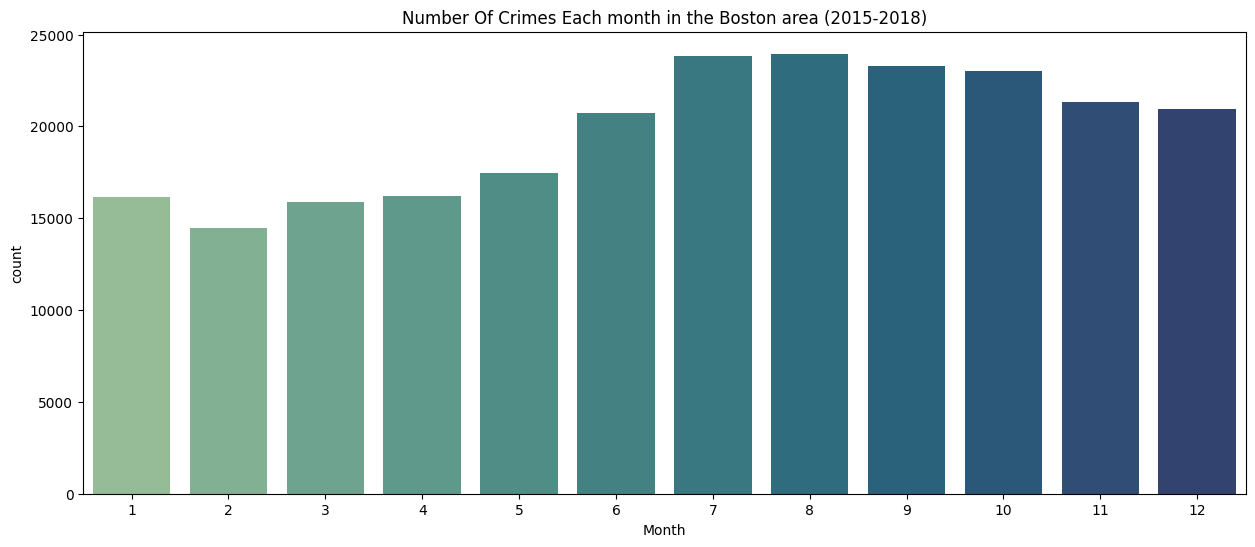

In [27]:
plt.subplots(figsize=(15,6))
sns.countplot('Month',data=data_slides,palette='crest')
plt.title('Number Of Crimes Each month in the Boston area (2015-2018)')

plt.show()



### Number Of Crimes Each Hour in the Boston area (2015-2018)


/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


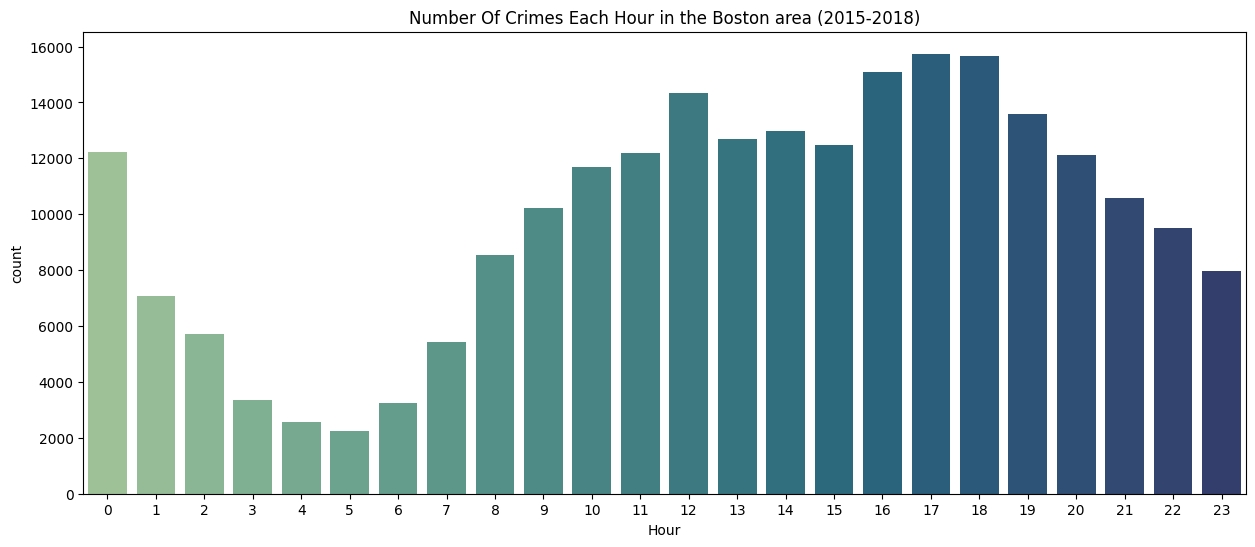

In [28]:
plt.subplots(figsize=(15,6))
sns.countplot('Hour',data=data_slides,palette='crest')

plt.title('Number Of Crimes Each Hour in the Boston area (2015-2018)')
plt.show()


### Number Of Crimes Activities By District in the Boston area (2015-2018)


/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


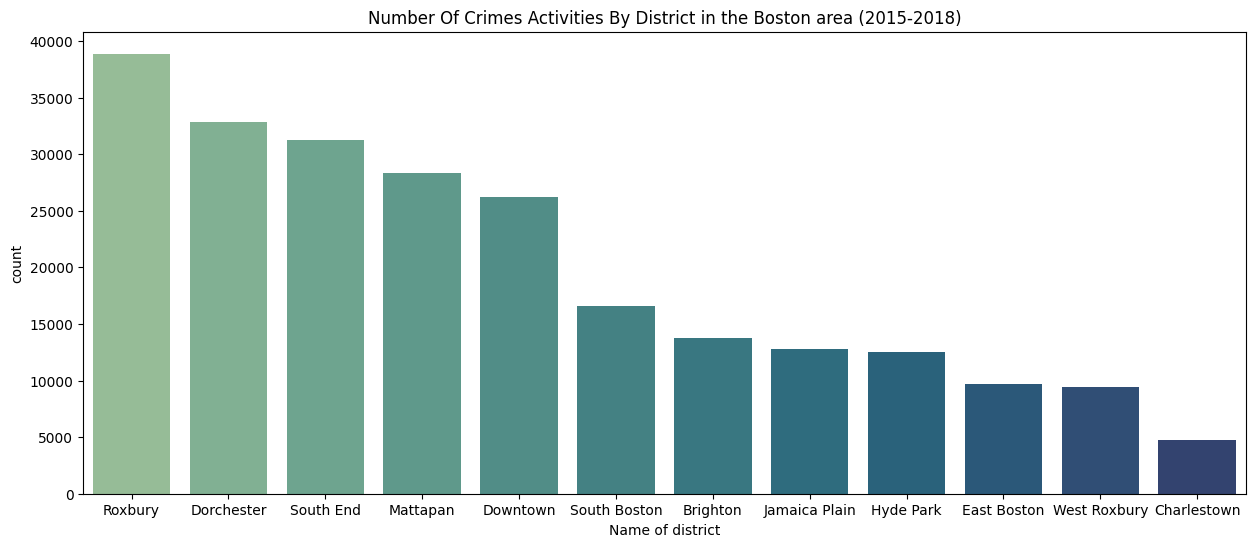

In [44]:
plt.subplots(figsize=(15,6))
sns.countplot('NAME',data=data_slides,palette='crest',order=data_slides['NAME'].value_counts().index)

plt.title('Number Of Crimes Activities By District in the Boston area (2015-2018)')
plt.xlabel("Name of district", fontsize=10)

plt.show()



### Number Of Crimes Each year


/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


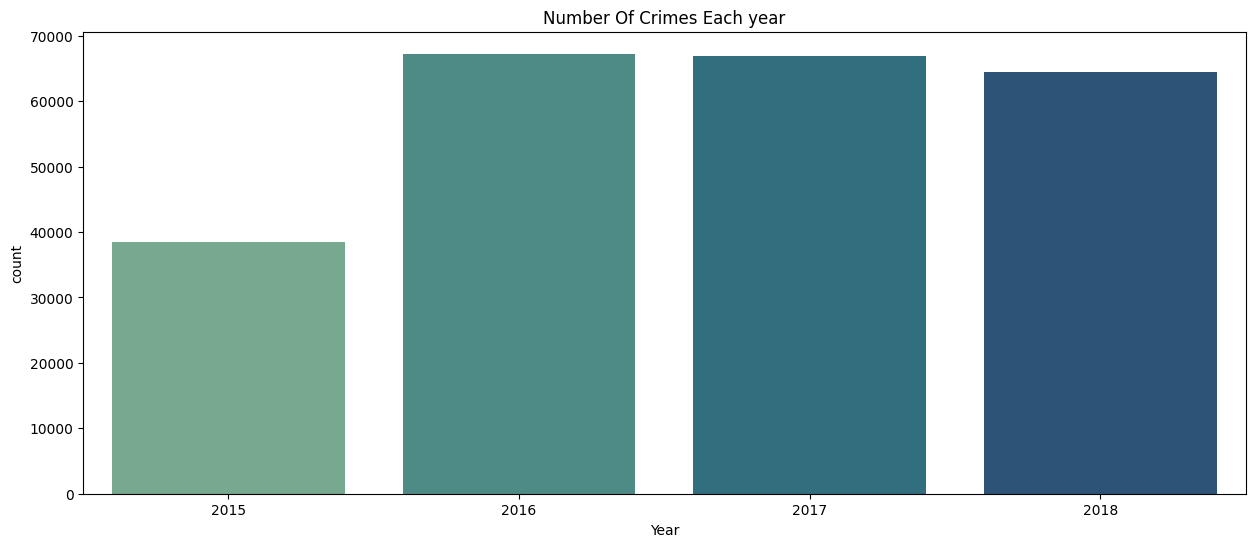

In [30]:
plt.subplots(figsize=(15,6))
sns.countplot('Year',data=data_slides,palette='crest')

plt.title('Number Of Crimes Each year')

plt.show()

### Most frequent crimes in the Boston area (2015-2018)


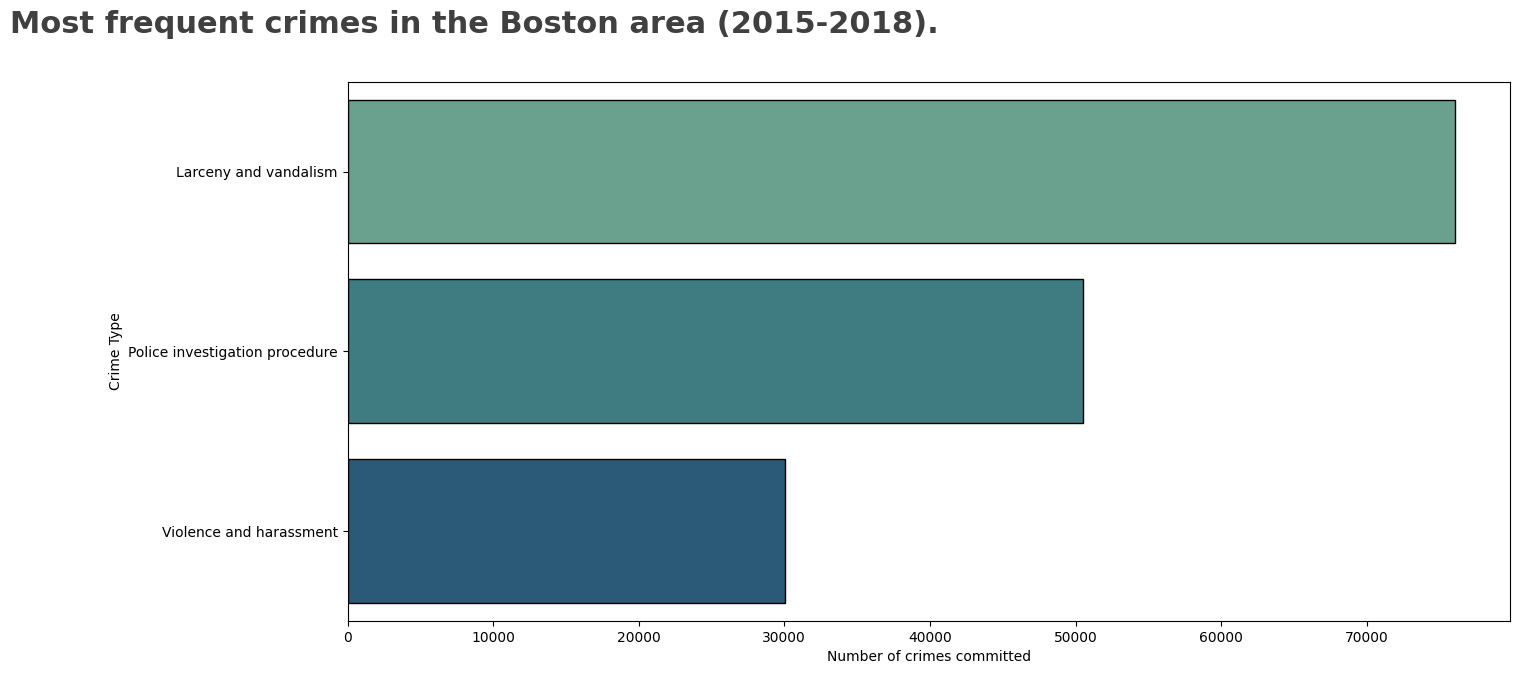

In [48]:
ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = data_slides["OFFENSE_CODE_GROUP"],order=data_slides["OFFENSE_CODE_GROUP"].value_counts()[:3].index, palette="crest",edgecolor="black")

plt.ylabel("Crime Type")
plt.xlabel("Number of crimes committed")


#Title
ax.text(x=-0.10,y=0.95,s="Most frequent crimes in the Boston area (2015-2018).",weight="bold",alpha=0.75, fontsize=22);




### Number Of Crimes Each day in the Boston area (2015-2018)


/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


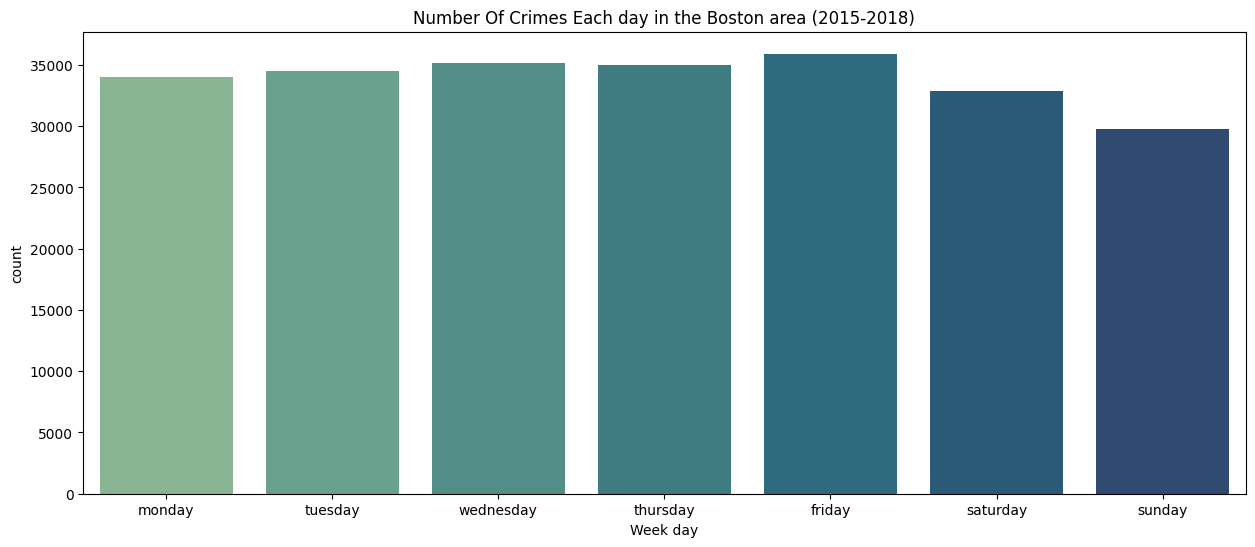

In [45]:
cats = [ 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
plt.subplots(figsize=(15,6))
sns.countplot('Day_of_week',data=data_slides,palette='crest',order=cats)

plt.xlabel("Week day")
plt.title('Number Of Crimes Each day in the Boston area (2015-2018)')
plt.show()




### Folium


In [37]:
import folium
from folium.plugins import HeatMap


#### Roxbury


In [38]:
data_slides.loc[data_slides.NAME == "Roxbury"][["LAT","LONG"]]


LAT       LONG
6324   42.328663 -71.085634
6334   42.315031 -71.083440
5984   42.322496 -71.069092
6333   42.309525 -71.082618
6300   42.305767 -71.080975
...          ...        ...
28454  42.314321 -71.079006
28453  42.305114 -71.082432
28452  42.331642 -71.107608
28451  42.332488 -71.083658
28440  42.308412 -71.088381

[38877 rows x 2 columns]

In [39]:
import folium
from folium.plugins import HeatMap


vand=data_slides[["LAT","LONG"]]



BostonMap=folium.Map(location=[42.356145,-71.064083],zoom_start=11)
HeatMap(data=vand, radius=16).add_to(BostonMap)

BostonMap


### Focus on Roxbury and distance


In [49]:
distance_avg


Average Distance
NAME                           
South End              1.862039
Mattapan               1.908636
Hyde Park              2.397613
Jamaica Plain          2.585737
Roxbury                2.989029
Dorchester             3.174444
Brighton               3.770867
East Boston            5.568626
Downtown               6.336657
West Roxbury          18.370045
South Boston          31.454220
Charlestown           58.758394

In [50]:
data_roxbury = data_slides[data_slides.NAME =="Roxbury"]
data_roxbury


INCIDENT_NUMBER              OFFENSE_CODE_GROUP  SHOOTING  \
6324       I152049702    Drugs and disorderly conduct         0   
6334       I152049509         Violence and harassment         0   
5984       I152052529           Larceny and vandalism         0   
6333       I152049518           Larceny and vandalism         0   
6300       I152049899           Larceny and vandalism         0   
...               ...                             ...       ...   
28454      I182105206        Fraud and law violations         0   
28453      I182105237  Police investigation procedure         0   
28452      I182105247  Police investigation procedure         0   
28451      I182105267  Police investigation procedure         0   
28440      I192000425           Larceny and vandalism         0   

         OCCURRED_ON_DATE        LAT       LONG     NAME  LAT_POLICE_STATION  \
6324  2015-06-15 07:30:00  42.328663 -71.085634  Roxbury           42.328894   
6334  2015-06-15 08:10:00  42.315031 -71.083440  Roxbury           42.328894   
5984  2015-06-15 09:00:00  42.322496 -71.069092  Roxbury           42.328894   
6333  2015-06-15 09:10:00  42.309525 -71.082618  Roxbury           42.328894   
6300  2015-06-15 12:15:00  42.305767 -71.080975  Roxbury           42.328894   
...                   ...        ...        ...      ...                 ...   
28454 2018-12-31 18:55:00  42.314321 -71.079006  Roxbury           42.328894   
28453 2018-12-31 19:12:00  42.305114 -71.082432  Roxbury           42.328894   
28452 2018-12-31 21:31:00  42.331642 -71.107608  Roxbury           42.328894   
28451 2018-12-31 23:02:00  42.332488 -71.083658  Roxbury           42.328894   
28440 2018-12-31 23:45:00  42.308412 -71.088381  Roxbury           42.328894   

       LONG_POLICE_STATION  Distance  Year  Month  Day Day_of_week  Hour  
6324            -71.085359  0.034220  2015      6   15      monday     7  
6334            -71.085359  1.549565  2015      6   15      monday     8  
5984            -71.085359  1.514792  2015      6   15      monday     9  
6333            -71.085359  2.165479  2015      6   15      monday     9  
6300            -71.085359  2.596760  2015      6   15      monday    12  
...                    ...       ...   ...    ...  ...         ...   ...  
28454           -71.085359  1.702537  2018     12   31      monday    18  
28453           -71.085359  2.655171  2018     12   31      monday    19  
28452           -71.085359  1.854267  2018     12   31      monday    21  
28451           -71.085359  0.423353  2018     12   31      monday    23  
28440           -71.085359  2.291002  2018     12   31      monday    23  

[38877 rows x 15 columns]

### Most frequent crimes in the Roxbury area (2015-2018)


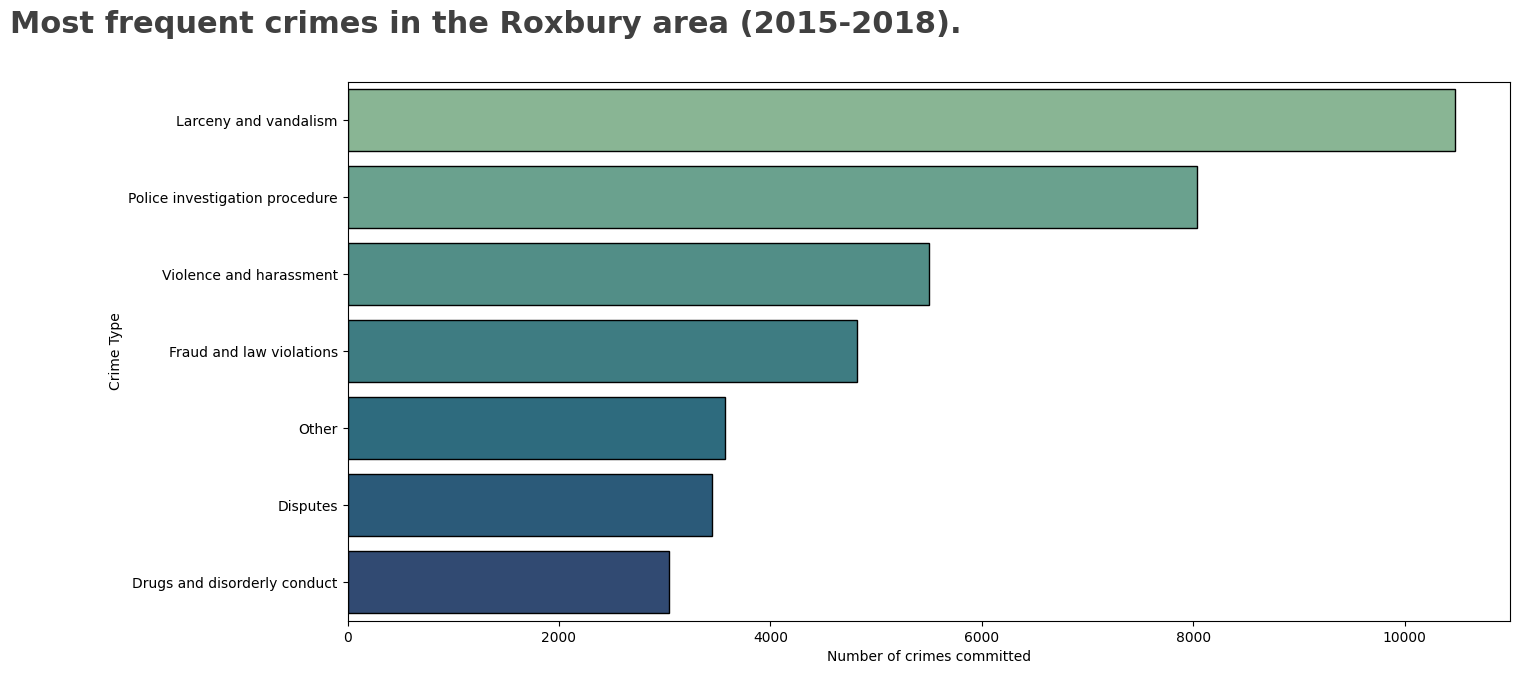

In [51]:
#Focus => Roxbury 

ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = data_roxbury["OFFENSE_CODE_GROUP"],order=data_roxbury["OFFENSE_CODE_GROUP"].value_counts()[:7].index, palette="crest",edgecolor="black")

plt.ylabel("Crime Type")
plt.xlabel("Number of crimes committed")


#Title
ax.text(x=-0.10,y=0.95,s="Most frequent crimes in the Roxbury area (2015-2018).",weight="bold",alpha=0.75, fontsize=22);




In [52]:
data_slides.groupby("NAME")["INCIDENT_NUMBER"].count()


NAME
Brighton         13788
Charlestown       4765
Dorchester       32875
Downtown         26260
East Boston       9691
Hyde Park        12551
Jamaica Plain    12802
Mattapan         28331
Roxbury          38877
South Boston     16617
South End        31258
West Roxbury      9406
Name: INCIDENT_NUMBER, dtype: int64

In [53]:
distance_avg_test = distance_avg.copy()
distance_avg_test["NB_INCIDENTS"] = data_slides.groupby("NAME")["INCIDENT_NUMBER"].count()
distance_avg_test.sort_values(by="NB_INCIDENTS")



Average Distance  NB_INCIDENTS
NAME                                         
Charlestown           58.758394          4765
West Roxbury          18.370045          9406
East Boston            5.568626          9691
Hyde Park              2.397613         12551
Jamaica Plain          2.585737         12802
Brighton               3.770867         13788
South Boston          31.454220         16617
Downtown               6.336657         26260
Mattapan               1.908636         28331
South End              1.862039         31258
Dorchester             3.174444         32875
Roxbury                2.989029         38877

### Linear regression 


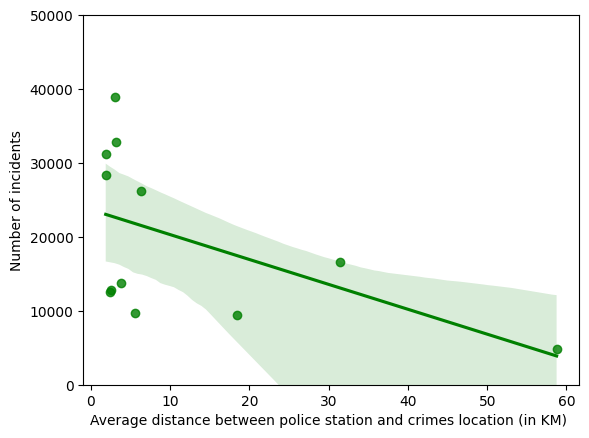

In [54]:
sns.regplot(data=distance_avg_test,x='Average Distance',y="NB_INCIDENTS",color="g");
plt.ylim(0, 50000)
plt.xlabel("Average distance between police station and crimes location (in KM) ")

plt.ylabel("Number of incidents");


### Least frequent crimes in the Roxbury area (2015-2018)


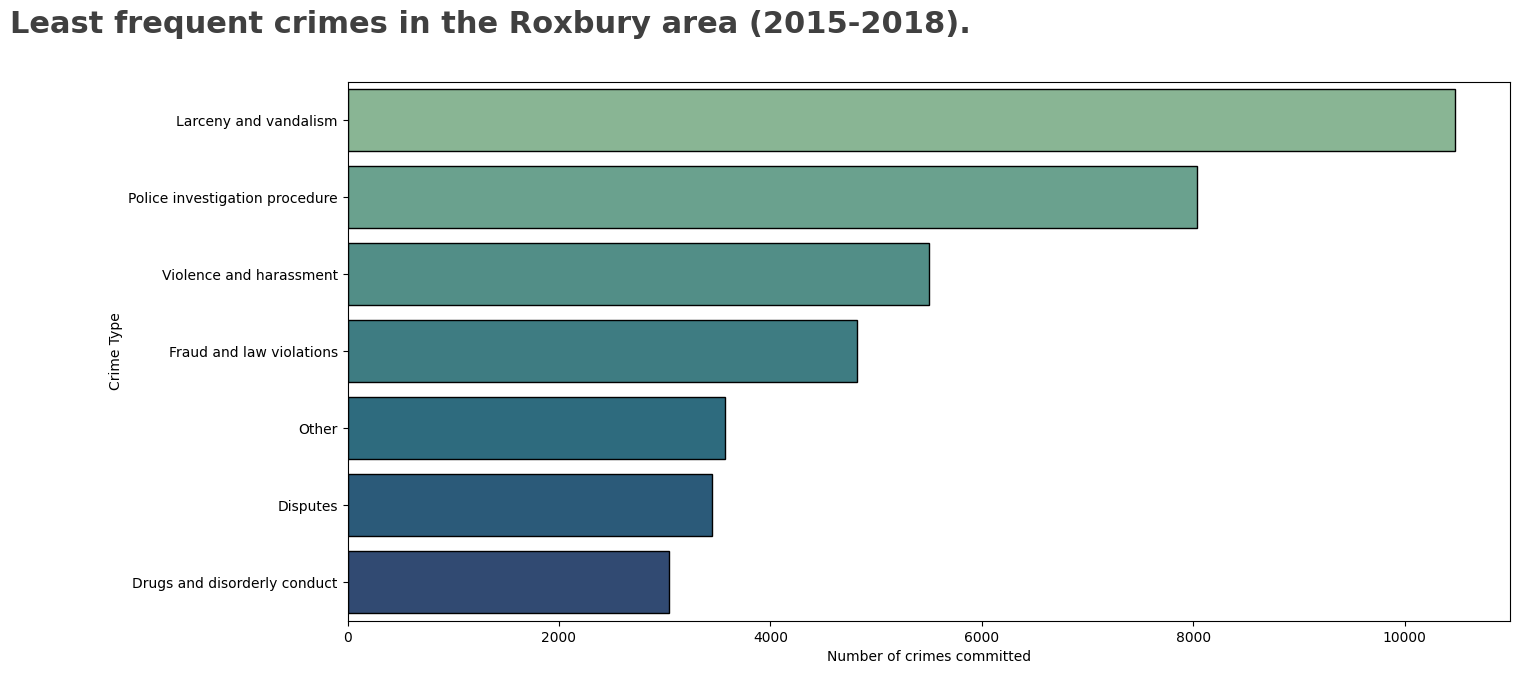

In [55]:
#Focus => Roxbury 

ax,fig = plt.subplots(figsize=(15,7))

#Plot
sns.countplot(y = data_roxbury["OFFENSE_CODE_GROUP"],order=data_roxbury["OFFENSE_CODE_GROUP"].value_counts()[-10:].index, palette="crest",edgecolor="black")




plt.ylabel("Crime Type")
plt.xlabel("Number of crimes committed")


#Title
ax.text(x=-0.10,y=0.95,s="Least frequent crimes in the Roxbury area (2015-2018).",weight="bold",alpha=0.75, fontsize=22);




### Number Of Crimes Each month in the Roxbury area (2015-2018)


/Users/Edouard_1/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


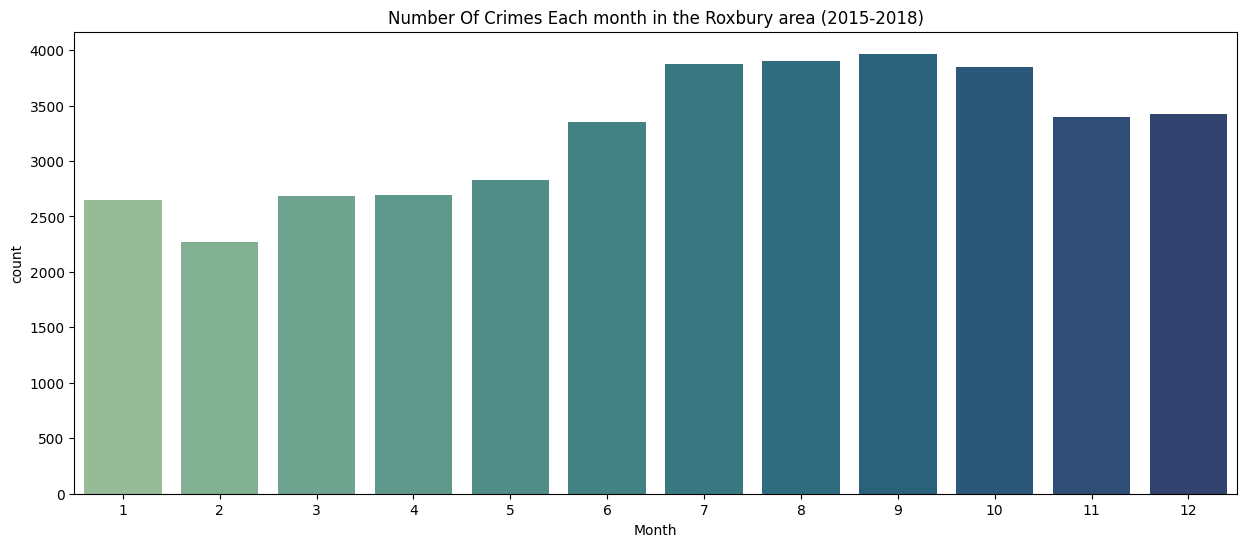

In [57]:
plt.subplots(figsize=(15,6))
sns.countplot('Month',data=data_roxbury,palette='crest')
plt.title('Number Of Crimes Each month in the Roxbury area (2015-2018)')

plt.show()

